In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

%matplotlib inline

In [ ]:
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/dataset_sms_spam_v1.csv

--2022-04-06 08:47:37--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/dataset_sms_spam_v1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128896 (126K) [text/plain]
Saving to: ‘dataset_sms_spam_v1.csv’

dataset_sms_spam_v1 100%[===================>] 125.88K  --.-KB/s    in 0.01s   

2022-04-06 08:47:37 (9.55 MB/s) - ‘dataset_sms_spam_v1.csv’ saved [128896/128896]



In [ ]:
data = pd.read_csv('dataset_sms_spam_v1.csv')
data.head()

,teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


# Text Preprocessing

In [ ]:
'''
Disini, kita tidak banyak melakukan preprocessing karena kita tidak ingin mengubah makna dari suatu kata pada kalimat
'''

import re

def text_preprocessing(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()                               # Menghapus whitespaces
  return text

In [ ]:
%time data['clean_teks'] = data['teks'].apply(text_preprocessing)

CPU times: user 23.3 ms, sys: 59 µs, total: 23.4 ms
Wall time: 26.9 ms


In [ ]:
data.sample(5)

,teks,label,clean_teks
483,Selamat! No Anda Terpilih M-dptkan kejutan HAD...,1,selamat no anda terpilih mdptkan kejutan hadia...
73,Gunakan GrabCar atau GrabTaxi & dapatkan disko...,2,gunakan grabcar atau grabtaxi dapatkan diskon...
387,"NASIB:Berbagi, berbakti Rutinkan 2 hal ini Mak...",1,nasibberbagi berbakti rutinkan hal ini maka r...
448,Pnjaman mudah tnpa jaminan. proses sangat cepa...,1,pnjaman mudah tnpa jaminan proses sangat cepat...
43,Buruan Download & Registrasi myCare di http://...,2,buruan download registrasi mycare di dan dap...


In [ ]:
data.to_csv('clean_dataset_sms_spam.csv')

# Word Embedding

## Word2Vec

In [ ]:
#import library
import gensim

In [ ]:
# Tokenize kata pada setiap kalimat
def tokenization(text):
  text = re.split('\W+', text)
  return text

sentences = data['clean_teks'].apply(lambda x: tokenization(x.lower()))
sentences

0       [promo, beli, paket, flash, mulai, gb, di, my,...
1       [gb, hari, hanya, rp, ribu, spesial, buat, and...
2       [plg, yth, sisa, kuota, flash, anda, kb, downl...
3       [plg, yth, sisa, kuota, flash, anda, kb, downl...
4       [gb, hari, hanya, rp, ribu, spesial, buat, and...
                              ...                        
1138    [yooo, sama, oke, nanti, aku, umumin, di, grup...
1139    [sebelumnya, ga, ad, nulis, kerudung, kirain, ...
1140                                [mba, mau, kirim, ya]
1141    [nama, beaok, bwrangkat, pagimau, cas, atay, t...
1142                    [no, bri, atas, nama, kamu, mana]
Name: clean_teks, Length: 1143, dtype: object

In [ ]:
# Defenisikan parameter training Word2Vec

MIN_COUNT = 1       # Mengabaikan semua kata dengan frekuensi total lebih rendah dari ini (opsional)
WINDOW = 5          # Window size. Jarak maksimum antara kata saat ini dan yang diprediksi dalam sebuah kalimat.
EPOCH = 10          # Jumlah iterasi (epoch).
SG = 1              # Algoritma pelatihan: 1 untuk skip-gram, 0 untuk CBOW.
SIZE = 5            # Dimensi vektor

In [ ]:
# Proses training Word2Vec

%%time 
model_word2vec = gensim.models.Word2Vec(sentences, size=SIZE, sg=SG, min_count=MIN_COUNT, window=WINDOW, iter=EPOCH)

CPU times: user 1.82 s, sys: 19.1 ms, total: 1.84 s
Wall time: 1.58 s


In [ ]:
# Save model
path = "word2vec.bin.gz"
model_word2vec.wv.save_word2vec_format(path, binary=True)

In [ ]:
# Cari nilai vektor dari kata 'hadiah'
model_word2vec.wv['hadiah']

array([-0.41845885, -0.32147726,  0.49585527, -0.0843215 , -3.4680526 ],
      dtype=float32)

In [ ]:
# Menemukan kata kata teratas yang paling mirip.
# Menghitung kesamaan dari vektor bobot proyeksi dari kata-kata yang diberikan dan vektor untuk setiap kata dalam model.

model_word2vec.wv.most_similar('hadiah')

[('selamat', 0.9996521472930908),
 ('terpilih', 0.9985349774360657),
 ('pemenang', 0.9977458715438843),
 ('mdptkan', 0.9973387718200684),
 ('mendpt', 0.9965212345123291),
 ('mendapatkan', 0.9958164691925049),
 ('indonesia', 0.995606005191803),
 ('meraih', 0.9955542087554932),
 ('undian', 0.9949235916137695),
 ('mdpt', 0.9946598410606384)]

In [ ]:
# Karena berdimensi 5, kita membutuhkan
# Kata-kata yang ingin kita plot vektornya
word_list = ['hadiah', 'promosi', 'sms', 'malam', 'makan', 'telkomsel', 'selamat', 'juta', 'nama', 'duit', 'uang']

# daftar vektor dari kata-kata tersebut
word_vectors = np.array([model_word2vec.wv[w] for w in word_list])
word_vectors

array([[-0.41845885, -0.32147726,  0.49585527, -0.0843215 , -3.4680526 ],
       [ 0.34932783, -0.38690042,  0.0509068 , -0.0430352 , -0.77744627],
       [ 1.4056178 , -0.22184414, -0.16179806,  0.02852002, -1.3623363 ],
       [ 0.7799209 , -0.6026715 , -0.13694608, -0.03441818, -1.3277912 ],
       [ 0.79305637, -0.69716585,  0.02810624, -0.05285832, -1.055632  ],
       [ 0.8333081 ,  0.10236358, -0.19822127, -0.3576031 , -1.8661792 ],
       [-0.31056312, -0.2802966 ,  0.38506147, -0.0091592 , -2.888227  ],
       [ 0.03922816, -0.06108119, -0.34660146, -0.33582366, -2.30744   ],
       [ 1.0009819 , -1.6090498 ,  0.3916152 ,  0.0292122 , -0.7851177 ],
       [ 0.50289863, -0.33798695, -0.0913626 , -0.11507731, -0.6807148 ],
       [ 0.20688015, -0.44525477, -0.17755836, -0.15634379, -1.9593883 ]],
      dtype=float32)

In [ ]:
# Reduksi dimensi vektor ke 2D menggunakan PCA
from sklearn.decomposition import PCA, KernelPCA

dimred = PCA(n_components=2, copy=False, whiten=True)
red_word_vectors = dimred.fit_transform(word_vectors)

In [ ]:
red_word_vectors

array([[ 1.9233403 ,  0.8686605 ],
       [-0.68166715, -0.01797632],
       [-0.6424437 , -1.0465757 ],
       [-0.4714366 , -0.04809304],
       [-0.70667756,  0.2673139 ],
       [ 0.09635116, -1.4639571 ],
       [ 1.3942248 ,  0.6213787 ],
       [ 0.75926167, -0.88542175],
       [-1.1741571 ,  2.1494482 ],
       [-0.8272081 , -0.37025192],
       [ 0.3304118 , -0.07452486]], dtype=float32)

In [ ]:
# Implementasi visualisasi dapat di cek pada laman berikut: https://ir.cs.ui.ac.id/alfan/tutorial/gensim_w2v.html

def plot(datas, labels, fc='yellow'):
  # plot the dots
  plt.subplots_adjust(bottom = 0.1)
  plt.scatter(datas[:, 0], datas[:, 1], marker='o')

  # annotate labels
  for label, x, y in zip(labels, datas[:, 0], datas[:, 1]):
    plt.annotate(label, \
                 xy=(x, y), xytext=(-15, 15), \
                 textcoords='offset points', ha='right', va='bottom', \
                 bbox=dict(boxstyle='round,pad=0.3', fc=fc, alpha=0.5), \
                 arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
  plt.show()

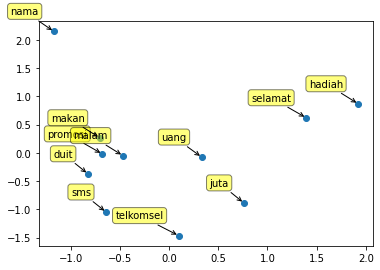

In [ ]:
plot(red_word_vectors, word_list)

## FastText

In [ ]:
!pip -q install fasttext

     |████████████████████████████████| 68 kB 4.1 MB/s 


In [ ]:
# Download dan unzip dataset
# Warning: proses download lama dan memakan diskspace yang besar
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gunzip cc.en.300.bin.gz

In [ ]:
import fasttext
ft_model = fasttext.load_model("cc.en.300.bin")

In [ ]:
print(ft_model['hadiah'])

In [ ]:
list_kalimat = ['saya lapar saya tidak makan','saya tidak lapar saya makan'] 
word_vectors_fasttext = np.array([ft_model[w] for w in list_kalimat])
pca = PCA(n_components=2, copy=False, whiten=True)

fasttext_word_vectors = pca.fit_transform(word_vectors_fasttext)

plot(word_vectors_fasttext, list_kalimat)

# Deep Learning for NLP

## LSTM

### Data Splitting

In [ ]:
# Tentukan kolom yang akan digunkan
data = data[['clean_teks', 'label']]
data

In [ ]:
# Buat data uji, data latih, dan data validasi
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.2, random_state=5)
data_train, data_val = train_test_split(data_train, test_size=0.25, random_state=5)

In [ ]:
# Lihat shape dari masing-masing data
print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

In [ ]:
# Pisahkan kolom fitur dan target (label)
trainX = np.array(data_train.iloc[:, 0])
trainY = np.array(data_train.iloc[:, 1])

testX = np.array(data_test.iloc[:, 0])
testY = np.array(data_test.iloc[:, 1])

valX = np.array(data_val.iloc[:, 0])
valY = np.array(data_val.iloc[:, 1])

In [ ]:
# One-hot encoding

trainY = pd.get_dummies(trainY).values
testY = pd.get_dummies(testY).values
valY = pd.get_dummies(valY).values

In [ ]:
print(trainY.shape)
print(testY.shape)
print(valY.shape)

In [ ]:
trainY

### Tokenizing Data

In [ ]:
'''
Proses vektorisasi teks dengan mengubah setiap teks menjadi token urutan bilangan int (setiap bilangan int menjadi indeks token dalam dictionary) 
'''
from keras.preprocessing.text import Tokenizer

In [ ]:
NUM_WORDS = 100       # Frekuensi kemunculan kata. Hanya num_words-1 yang akan disimpan pada dictionary. Berarti kata dengan kemunculan >=100 tidak digunakan.
OOV_TOKEN = '<unk>'   # Token khusus untuk mengganti kata yang tidak terdaftar dalam dictionary.

tokenizer = Tokenizer(num_words=100, oov_token=OOV_TOKEN, lower=True)   
tokenizer.fit_on_texts(trainX)

# Tambahkan token padding untuk menyamakan ukuran dimensi fitur input ke LSTM
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

word_index = tokenizer.word_index

In [ ]:
# Lihat dictionary yang telah dibuat proses tokenisasi
print(word_index)

In [ ]:
len(word_index)

### Text to Sequences

In [ ]:
'''
Proses mengubah token teks menjadi urutan bilangan int.
'''
train_seqs = tokenizer.texts_to_sequences(trainX)
val_seqs = tokenizer.texts_to_sequences(valX)
test_seqs = tokenizer.texts_to_sequences(testX)

In [ ]:
# Lihat hasil dari text to sequences
# Setiap bilang int merujuk pada indeks token yang ada dalam dictionary
print(train_seqs)

In [ ]:
print(trainX[10])
print(train_seqs[10])

### Padding & Truncate

In [ ]:
'''
Proses mengubah data dari sequence menjadi array bentuk 2D Numpy (num_samples, num_timesteps). 
num_timesteps adalah argumen maxlen jika disediakan, atau panjang dari sequence terpanjang dalam daftar.

Sequence yang lebih pendek dari num_timesteps diisi dengan nilai hingga panjangnya sama dengan num_timesteps (padding).
Sequence yang lebih panjang dari num_timesteps dipotong sehingga sesuai dengan panjang yang diinginkan (truncate).
'''

from keras.preprocessing.sequence import pad_sequences

In [ ]:
# Lihat distribusi jumlah kata dalam X_train_seq.
# Pada contoh ini, max_len tidak ditentukan, sehingga semua data dari sequence akan di padding menjad panjang sesuai dengan sequnce terpanjang
l = [len(i) for i in train_seqs]
l = np.array(l)

print('minimum number of words: {}'.format(l.min()))
print('median number of words: {}'.format(np.median(l)))
print('average number of words: {}'.format(l.mean()))
print('maximum number of words: {}'.format(l.max()))

In [ ]:
PADDING = 'pre' # Terdapat dua pilihan dalam melakukan padding 'pre' or 'post'.

train_seqs = pad_sequences(train_seqs, padding=PADDING)
val_seqs = pad_sequences(val_seqs, padding=PADDING)
test_seqs = pad_sequences(test_seqs, padding=PADDING)

In [ ]:
print(trainX[10])
print(train_seqs[10])

### Define Model

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Flatten

model_LSTM = Sequential()
model_LSTM.add(Embedding(len(word_index), 200))
model_LSTM.add(LSTM(100))
model_LSTM.add(Dense(3, activation='softmax'))

In [ ]:
model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training

In [ ]:
%%time

EPOCH = 10
BATCH_SIZE = 64

history_LSTM = model_LSTM.fit(train_seqs, trainY, epochs=EPOCH, batch_size=BATCH_SIZE, validation_data=(val_seqs, valY))

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [ ]:
plot_graphs(history_LSTM, 'accuracy')
plot_graphs(history_LSTM, 'loss')

In [ ]:
print('\nEpoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss')
for i in range(EPOCH):
  print('{:8d} {:10f} \t {:10f} \t {:10f} \t {:10f}'.format(i + 1, history_LSTM.history['accuracy'][i], history_LSTM.history['loss'][i], history_LSTM.history['val_accuracy'][i], history_LSTM.history['val_loss'][i]))

### Evaluate

In [ ]:
# Lakukan prediksi pada data uji
y_pred = np.argmax(model_LSTM.predict(test_seqs), axis=1)
y_true = np.argmax(testY, axis=1)

loss, accuracy = model_LSTM.evaluate(test_seqs, testY)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_true))

## LSTM + Word Embedding

In [ ]:
# Load word2vec
from gensim.models import KeyedVectors

reloaded_word_vectors = KeyedVectors.load_word2vec_format(path, binary=True)

In [ ]:
print(reloaded_word_vectors.vocab)

### Token to Embedding

In [ ]:
# Buat fungsi untuk mengubah kata pada kalimat sesuai dengan word2vec, gunakan token kalimat sebagai input 'sentences'
def embed(token_kalimat):
  embedding = []
  for sentences in token_kalimat:
    sentencevec = []
    for w in sentences:
      if w in reloaded_word_vectors.vocab:
        sentencevec.append(reloaded_word_vectors[w])
      else :
        sentencevec.append(np.zeros((5)))
    embedding.append(sentencevec)
  return embedding

### Padding

In [ ]:
# Buat fungsi untuk melakukan padding

max_length = 100

def padding(vec):
  padded = []
  for i, v in enumerate(vec) :
    vector = []
    if len(v) < max_length :
      pad_count = max_length - len(v)
      pad = np.zeros((pad_count, 5))
      vector = np.append(v, pad, axis=0)
    else :
      vector = v[:max_length]
    padded.append(vector)
  return padded

In [ ]:
trainX_we = embed(trainX)
testX_we = embed(testX)
valX_we = embed(valX)

trainX_we = np.array(padding(trainX_we))
testX_we = np.array(padding(testX_we))
valX_we = np.array(padding(valX_we))

In [ ]:
print(trainX_we.shape)
print(testX_we.shape)
print(valX_we.shape)

### Define Model

In [ ]:
model_LSTM_we = Sequential()
model_LSTM_we.add(LSTM(100, return_sequences=True, input_shape=(100,5)))
model_LSTM_we.add(Dense(3, activation='softmax'))

In [ ]:
model_LSTM_we.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
%%time

EPOCH = 10
BATCH_SIZE = 64

history_LSTM = model_LSTM.fit(train_seqs, trainY, epochs=EPOCH, batch_size=BATCH_SIZE, validation_data=(val_seqs, valY))

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [ ]:
plot_graphs(history_LSTM, 'accuracy')
plot_graphs(history_LSTM, 'loss')

In [ ]:
print('\nEpoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss')
for i in range(EPOCH):
  print('{:8d} {:10f} \t {:10f} \t {:10f} \t {:10f}'.format(i + 1, history_LSTM.history['accuracy'][i], history_LSTM.history['loss'][i], history_LSTM.history['val_accuracy'][i], history_LSTM.history['val_loss'][i]))

In [ ]:
# Lakukan prediksi pada data uji
y_pred = np.argmax(model_LSTM.predict(test_seqs), axis=1)
y_true = np.argmax(testY, axis=1)

loss, accuracy = model_LSTM.evaluate(test_seqs, testY)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_pred, y_true))